In [15]:
%pylab inline
from multiprocessing import Pool
import pickle
import scipy.integrate
import scipy.interpolate

Populating the interactive namespace from numpy and matplotlib


/home/akbhowmi/miniconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [16]:
f=open('parameters_for_monte_carlo.txt')
lines=f.readlines()
for line in lines:
    if ('-------' not in line):
            #line= line.replace('=',' ')
            #line=line.split()
            print line
            exec(line)


#--------------------------Activate only if you want to override the parameter values from the input file---------------
Initial_values=[0.01,0.01,0.01,0.01,0.01,0.01]

Final_values=[200.,200.,200.,200.,200.,200.]
#Final_values=[0.2,0.2,0.2,0.2,0.2,0.2]

Integrate_over_logspace=True

PARALLEL_PROCESSORS=True
#--------------------------------------------------------------------------------------------------------
Initial_values=numpy.array(Initial_values)
Final_values=numpy.array(Final_values)

if ((len(Initial_values)!=Dimensions)or(len(Final_values)!=Dimensions)):
    print "Warning!! Dinensional mismatch"


    
    


Dimensions=6

Initial_values=[0.001,0.001,0.001,0.001,0.001,0.001]

Final_values=[1.,1.,1.,1.,1.,1.]

Number_of_points=10

Integrate_over_logspace=True

TEST_MODE=True

PARALLEL_PROCESSORS=True

Number_of_processors=16



redshift_range=[8.0]

stellar_mass_cut_range=[9.0]





In [60]:
#-----------------------------DO NOT CHANGE---------------------------------------------
arc_sec_to_radians=1./(180/3.14)*(1./3600.)
#---------------------------------------------------------------------------------------


f=open('cosmology.txt')
lines=f.readlines()
for line in lines:
    if ('-------' not in line):
        #line= line.replace('=',' ')
        #line=line.split()
        print line
        exec(line)


#---------------------------Function definitions-----------------------------------------
H = lambda z: H0*(om0*(1+z)**(3) + oml)**0.5

def box_size_to_delta_z(z_mid,BOX_LENGTH):
    def er(a,zz):
        return numpy.subtract(BOX_LENGTH,scipy.integrate.quad(lambda z:c/H(z),zz-a/2,zz+a/2))[0]
    return scipy.optimize.newton(er,2,args=(z_mid,))

def delta_z_to_box_size(z_mid,delta_z):
    #print "integrating from", z_mid-delta_z/2," to ",z_mid+delta_z/2
    box_size=scipy.integrate.quad(lambda z:c/H(z),z_mid-delta_z/2,z_mid+delta_z/2)[0]
    return box_size

def get_survey_dimensions(central_redshift,redshift_width,survey_length_in_arc_sec):
    distance_to_central_redshift=comoving_distance(0,central_redshift)
    print "comoving_distance:",distance_to_central_redshift/h
    survey_length_in_radians=survey_length_in_arc_sec*arc_sec_to_radians
    survey_length_in_cmpc_h=survey_length_in_radians*distance_to_central_redshift
    redshift_width_in_Mpc=delta_z_to_box_size(central_redshift,redshift_width)
    survey_dimensions=numpy.array([survey_length_in_cmpc_h,survey_length_in_cmpc_h*survey_aspect_ratio,redshift_width_in_Mpc])
    return survey_dimensions
    

def comoving_distance(z_low,z_up):
    box_size=scipy.integrate.quad(lambda z:c/H(z),z_low,z_up)[0]
    return box_size

#-----------------------------------------------------------------------------------------------------------------------
if Integrate_over_logspace:
    def test_function(input_array):
        modified_input_array=10**input_array
        xi=numpy.product(modified_input_array)**N
        #xi=3.
        return xi*numpy.product(modified_input_array)
    
    def correlation_function(input_array):
        modified_input_array=10**input_array
        x1,y1,z1,x2,y2,z2=modified_input_array
        r=numpy.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)+(z1-z2)*(z1-z2))
        #print numpy.sqrt(3.)*x2,numpy.sqrt(3.)*y2,numpy.sqrt(3.)*z2,r
        xi=10**power_law(numpy.log10(r),fitted_exponent,fitted_normalization)
        return xi*numpy.product(modified_input_array)
    
    def linear_dark_matter(input_array):
        modified_input_array=10**input_array
        x1,y1,z1,x2,y2,z2=modified_input_array
        r=numpy.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)+(z1-z2)*(z1-z2))
        #print numpy.sqrt(3.)*x2,numpy.sqrt(3.)*y2,numpy.sqrt(3.)*z2,r
        xi=10**gen_dm_corr(numpy.log10(r))
        if ((NON_LINEAR_POWER_SPECTRUM==1)&(r<10.)):
            xi=10**gen_dm_corr_nl(numpy.log10(r))
        #xi=3.    
        return xi*numpy.product(modified_input_array)
    
else:
    def test_function(input_array):
        return numpy.product(input_array)**N
    
    def correlation_function(input_array):
        modified_input_array=input_array
        x1,y1,z1,x2,y2,z2=modified_input_array
        r=numpy.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)+(z1-z2)*(z1-z2))
        #print numpy.sqrt(3.)*x2,numpy.sqrt(3.)*y2,numpy.sqrt(3.)*z2,r
        xi=10**power_law(numpy.log10(r),fitted_exponent,fitted_normalization)
        return xi
    
    def linear_dark_matter(input_array):
        modified_input_array=10**input_array
        x1,y1,z1,x2,y2,z2=modified_input_array
        r=numpy.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)+(z1-z2)*(z1-z2))
        #print numpy.sqrt(3.)*x2,numpy.sqrt(3.)*y2,numpy.sqrt(3.)*z2,r
        xi=10**gen_dm_corr(numpy.log10(r))
        if ((NON_LINEAR_POWER_SPECTRUM==1)&(r<10.)):
            xi=10**gen_dm_corr_nl(numpy.log10(r))
        #xi=3.
        return xi

def power_law(log_distance,exponent,normalization):
    return exponent*log_distance+normalization
    
def get_test_integral():
    print "Check Final values:",Final_values
    print "Check Initial values:",Initial_values
    if (Integrate_over_logspace):
        Initial_values_temp=numpy.log10(Initial_values)
        Final_values_temp=numpy.log10(Final_values)
    else:
        Initial_values_temp=Initial_values
        Final_values_temp=Final_values
    print Initial_values_temp
    print Final_values_temp
    print numpy.product(((10**Final_values_temp)**(N+1)-(10**Initial_values_temp)**(N+1))/(N+1))
    widths=Final_values_temp-Initial_values_temp
    scaled_points=numpy.random.rand(Number_of_points,Dimensions)
    actual_points=scaled_points*widths+Initial_values_temp
    #---------------------------------Testing the range----------------------------------
    print "Testing the range"
    tolerance=1e-2
    t_actual_points=numpy.transpose(actual_points)
    for i in range(0,Dimensions):
        left_edge_gap=numpy.abs(numpy.amin(t_actual_points[i])-Initial_values_temp[i])
        right_edge_gap=numpy.abs(numpy.amax(t_actual_points[i])-Final_values_temp[i])
        if (left_edge_gap>tolerance):
            print "Warning! Range may not be correct for axis ",i," with left_edge_gap ",left_edge_gap
        if (right_edge_gap>tolerance):
            print "Warning! Range may not be correct for axis ",i," with right_edge_gap ",right_edge_gap
    #--------------------------------Performing a test integration-----------------------------
    if (TEST_MODE):
        if (PARALLEL_PROCESSORS):
            print "parallel calculation"
            p=Pool(Number_of_processors)
            values=numpy.array(p.map(test_function,actual_points)) 
            p.close()
        else:
            print "serial calculation"
            
            values=numpy.array([test_function(point) for point in actual_points]) 
    
        phase_space_volume=numpy.product(widths)
        integral=numpy.average(values)*phase_space_volume
    
    
    
        if (Integrate_over_logspace):
            integral*=numpy.log(10)**Dimensions
            analytical_integral=numpy.product(((10**Final_values_temp)**(N+1)-(10**Initial_values_temp)**(N+1))/(N+1))
        else:
            analytical_integral=numpy.product((Final_values_temp**(N+1)-Initial_values_temp**(N+1))/(N+1))
        return integral,analytical_integral
    
    else:
        if (PARALLEL_PROCESSORS):
            print "parallel calculation"
            p=Pool(Number_of_processors)
            
            if (LINEAR_DARK_MATTER_MODE):
                values=numpy.array(p.map(linear_dark_matter,actual_points)) 
                p.close()   
            else:    
                values=numpy.array(p.map(correlation_function,actual_points)) 
                p.close()
        else:
            print "serial calculation"
            values=numpy.array([correlation_function(point) for point in actual_points]) 

        #print "Volume averaged correlation function", numpy.average(values)
    
        phase_space_volume=numpy.product(widths)
        integral=numpy.average(values)*phase_space_volume
        if (Integrate_over_logspace):
            integral*=numpy.log(10)**Dimensions
        return integral
    


om0=0.2814		#Matter content

oml=0.7186		#Dark energy content

H0=100.			#Hubble parameter

h=0.697			#hubble parameter

c=3e5			#speed of light in km/sec/Mpc h





In [61]:
z=1.
delta_z_to_box_size(1.,2.)/0.693

5322.0188228356365

In [62]:
survey_type='JWST'
prefix='survey_specifications_'
f=open(prefix+survey_type+'.txt')
lines=f.readlines()
for line in lines:
    if ('-------' not in line):
            #line= line.replace('=',' ')
            #line=line.split()
            print line
            exec(line)    
dimensions=get_survey_dimensions(central_redshift,redshift_width,survey_length_in_arc_sec)
Final_values=numpy.append(dimensions,dimensions)

smallest_scale=get_survey_dimensions(central_redshift,redshift_width,survey_resolution_in_arc_sec)[0]

#print smallest_scale


survey_length_in_arc_sec=250.

survey_aspect_ratio=0.5

redshift_width=0.46

central_redshift=8

survey_resolution_in_arc_sec=0.1





comoving_distance: 9191.65681882
comoving_distance: 9191.65681882


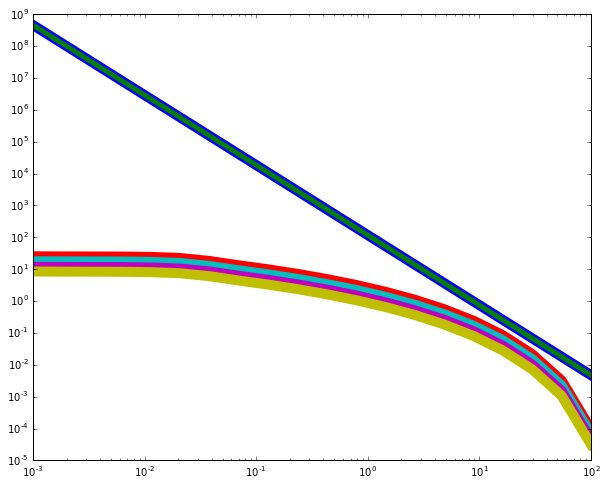

In [67]:
#-----------------------------------Testing functional forms and comparing steepness with test functions
NON_LINEAR_POWER_SPECTRUM=0

plt.figure(figsize=(10,8))
for redshift in redshift_range:
    for stellar_mass_cut in stellar_mass_cut_range:
        fitted_exponent,fitted_normalization,fitted_exponent_error,fitted_normalization_error=pickle.load(open('./galaxy_correlation_functions_power_law_models/power_law_modeling_paramaters_z%.1f_%.1f_SM_cut_galaxy_COM.pickle'%(redshift,stellar_mass_cut)))
        r_space=numpy.logspace(-3,2,20)
        xi_space=[]
        for r in r_space:
            x=r*numpy.sqrt(1./3.)
            #print "priginal", r
            point=numpy.array([1e-8,1e-8,1e-8,x,x,x])
            if Integrate_over_logspace:
                point=numpy.log10(point)
                xi_space.append(correlation_function(point)/numpy.product(10**point))
            else:
                xi_space.append(correlation_function(point))



            #print "--------------"
        xi_space=numpy.array(xi_space)
        plt.loglog(r_space,xi_space,linewidth=10)
        
        r_space_original,xi_space_original=pickle.load(open('./galaxy_correlation_functions_power_law_models/power_law_modeling_xi_z%.1f_%.1f_SM_cut_galaxy_COM.pickle'%(redshift,stellar_mass_cut)))
        plt.loglog(r_space_original,xi_space_original,linewidth=5)

xi_space=[]        

N=-1
for r in r_space:
            x=r*numpy.sqrt(1./3.)
            #print "priginal", r
            point=numpy.array([1e-8,1e-8,1e-8,x,x,x])
            if Integrate_over_logspace:
                point=numpy.log10(point)
                xi_space.append(test_function(point)/numpy.product(10**point))
                
            else:
                xi_space.append(test_function(point))
                
                
xi_space=numpy.array(xi_space)
#plt.loglog(r_space,xi_space/1e55,linewidth=5)

for redshift in [0.6,1.0,1.5,2.0]:
        r_dm,xi_dm=pickle.load(open('linear_matter_correlation/z%.2f_correlation.pickle'%redshift))
        mask=(xi_dm>0)#&(r_dm<10.)
        gen_dm_corr=scipy.interpolate.interp1d(numpy.log10(r_dm[mask]),numpy.log10(xi_dm[mask]),fill_value='extrapolate')
        
        r_dm_nl,xi_dm_nl=pickle.load(open('../project_3/dm_correlation_functions_mb2/xi_z%.2f.pickle'%redshift))    
        gen_dm_corr_nl=scipy.interpolate.interp1d(numpy.log10(r_dm_nl[xi_dm_nl>0]),numpy.log10(xi_dm_nl[xi_dm_nl>0]),fill_value='extrapolate')

        
        r_space=numpy.logspace(-3,2,20)
        xi_space=[]
        for r in r_space:
            x=r*numpy.sqrt(1./3.)
            #print "priginal", r
            point=numpy.array([1e-8,1e-8,1e-8,x,x,x])
            if Integrate_over_logspace:
                point=numpy.log10(point)
                xi_space.append(linear_dark_matter(point)/numpy.product(10**point))
            else:
                xi_space.append(linear_dark_matter(point))



            #print "--------------"
        xi_space=numpy.array(xi_space)
        plt.loglog(r_space,xi_space,linewidth=10)
        




    

Check Final values: [ 100.  100.  100.  100.  100.  100.]
Check Initial values: [ 0.01  0.01  0.01  0.01  0.01  0.01]
[-2. -2. -2. -2. -2. -2.]
[ 2.  2.  2.  2.  2.  2.]
753555.105717
Testing the range
parallel calculation
Average correlation function: 7.52402907381e-07
Check Final values: [ 100.  100.  100.  100.  100.  100.]
Check Initial values: [ 0.001  0.001  0.001  0.001  0.001  0.001]
[-3. -3. -3. -3. -3. -3.]
[ 2.  2.  2.  2.  2.  2.]
6448649.43521
Testing the range
parallel calculation
Average correlation function: 6.46410490551e-06
Check Final values: [ 100.  100.  100.  100.  100.  100.]
Check Initial values: [ 0.0001  0.0001  0.0001  0.0001  0.0001  0.0001]
[-4. -4. -4. -4. -4. -4.]
[ 2.  2.  2.  2.  2.  2.]
44282745.0969
Testing the range
parallel calculation
Average correlation function: 4.43903658477e-05
Check Final values: [ 100.  100.  100.  100.  100.  100.]
Check Initial values: [  1.00000000e-05   1.00000000e-05   1.00000000e-05   1.00000000e-05
   1.00000000e-05   

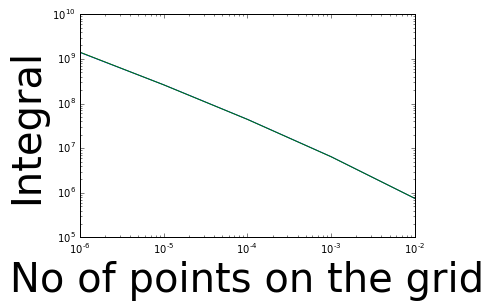

In [69]:
#-----------------------------------Testing convergence w.r.t minimum scale-----------------------------

TEST_MODE=1
smallest_length_scale=1e-4
Number_of_points=100000

smallest_length_scale_space=numpy.array([1e-2,1e-3,1e-4,1e-5,1e-6])
test_integral_space=[]
test_analytical_integral_space=[]
N=-1.1
for smallest_length_scale in smallest_length_scale_space :
    Initial_values=numpy.array([smallest_length_scale]*Dimensions)
    Final_values=numpy.array([100.]*Dimensions)
    integrals=get_test_integral()
    test_integral_space.append(integrals[0])
    test_analytical_integral_space.append(integrals[1])
    Phase_space_volume_sq=numpy.product(Final_values-Initial_values)
    print "Average correlation function:", integrals[0]/Phase_space_volume_sq
    
    
    
    
plt.plot(smallest_length_scale_space,test_integral_space,label='Numerical integration')
plt.plot(smallest_length_scale_space,test_analytical_integral_space,label='Analytical integration')
plt.xlabel('No of points on the grid',fontsize=40)
plt.ylabel('Integral',fontsize=40)

plt.xscale('log')
plt.yscale('log')
#



In [70]:
Initial_values

array([  1.00000000e-06,   1.00000000e-06,   1.00000000e-06,
         1.00000000e-06,   1.00000000e-06,   1.00000000e-06])

In [71]:
TEST_MODE=1
test_integral_space=[]
test_analytical_integral_space=[]
Number_of_points_space=[5,10,100,1000,10000,100000][:]
N=-1.1
for Number_of_points in Number_of_points_space:
        print Number_of_points
        
        Initial_values=numpy.array([smallest_length_scale]*Dimensions)
        Final_values=numpy.array([100.]*Dimensions)
        integrals=get_test_integral()
        test_integral_space.append(integrals[0])
        test_analytical_integral_space.append(integrals[1])
        
        Phase_space_volume_sq=numpy.product(Final_values-Initial_values)
        print "Average correlation function:", integrals[0]/Phase_space_volume_sq

5
Check Final values: [ 100.  100.  100.  100.  100.  100.]
Check Initial values: [  1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
[-6. -6. -6. -6. -6. -6.]
[ 2.  2.  2.  2.  2.  2.]
1413701749.35
Testing the range
Warning! Range may not be correct for axis  0  with left_edge_gap  3.17649212412
Warning! Range may not be correct for axis  0  with right_edge_gap  0.555762366963
Warning! Range may not be correct for axis  1  with left_edge_gap  0.874678375633
Warning! Range may not be correct for axis  1  with right_edge_gap  0.740317889672
Warning! Range may not be correct for axis  2  with left_edge_gap  1.23753333631
Warning! Range may not be correct for axis  2  with right_edge_gap  1.71939892528
Warning! Range may not be correct for axis  3  with left_edge_gap  0.568578900037
Warning! Range may not be correct for axis  3  with right_edge_gap  0.559881651723
Warning! Range may not be correct for axis  4  with left_edge_gap  1.289

[1413701749.3453681, 1413701749.3453681, 1413701749.3453681, 1413701749.3453681, 1413701749.3453681, 1413701749.3453681]
[302228101.45904708, 1966334581.046648, 1505232629.5577755, 1410428273.6119943, 1371954293.7759345, 1422526522.7483518]
[ 0.21378491  1.3909119   1.06474554  0.99768447  0.9704694   1.00624232]


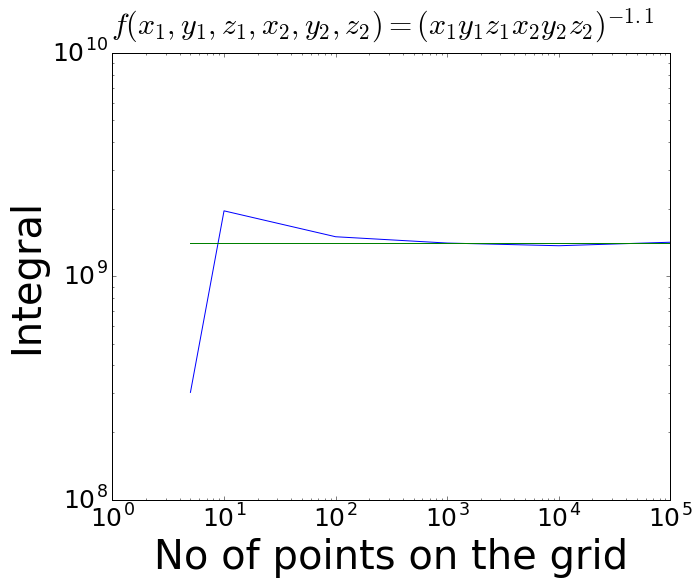

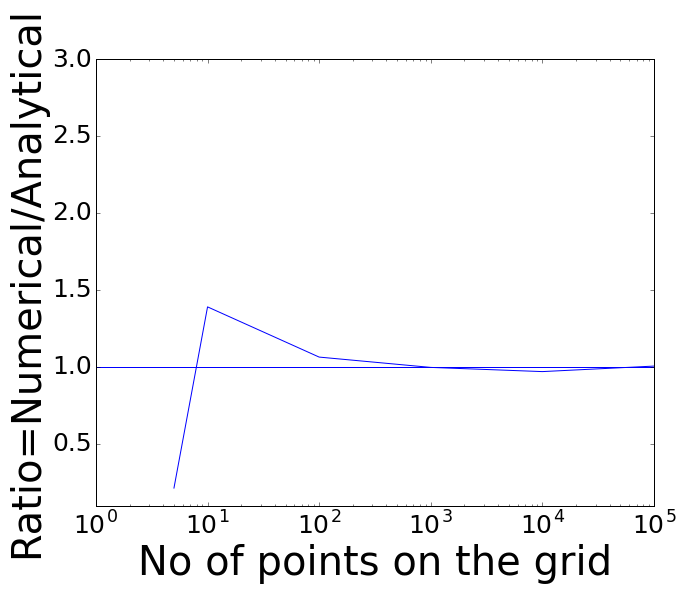

In [72]:
plt.figure(figsize=(10,8))
plt.suptitle('$f(x_1,y_1,z_1,x_2,y_2,z_2)=(x_1 y_1 z_1 x_2 y_2 z_2)^{%.1f}$'%N,fontsize=30)
plt.plot(Number_of_points_space,test_integral_space,label='Numerical integration')
plt.plot(Number_of_points_space,test_analytical_integral_space,label='Analytical integration')

plt.xlabel('No of points on the grid',fontsize=40)

plt.ylabel('Integral',fontsize=40)

plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.figure(figsize=(10,8))
plt.plot(Number_of_points_space,numpy.array(test_integral_space)/numpy.array(test_analytical_integral_space),label='Analytical integration')
plt.axhline(1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.ylim(0.1,3)


print test_analytical_integral_space

print test_integral_space

print numpy.array(test_integral_space)/numpy.array(test_analytical_integral_space)
plt.ylabel('Ratio=Numerical/Analytical',fontsize=40)

plt.xlabel('No of points on the grid',fontsize=40)

plt.xscale('log')
#plt.yscale('log')

In [75]:
#-----------------------------------Testing convergence w.r.t minimum scale-----------------------------

TEST_MODE=1
smallest_length_scale=1e-4
Number_of_points=100000

LINEAR_DARK_MATTER_MODE=0
#------------------------------------------------------------------------------------------

smallest_length_scale_space=numpy.array([1e-2,1e-3,1e-4,1e-5,1e-6])
integral_space=[]
test_analytical_integral_space=[]
N=-1.1
for smallest_length_scale in smallest_length_scale_space :
    Initial_values=numpy.array([smallest_length_scale]*Dimensions)
    Final_values=numpy.array([100.]*Dimensions)
    integrals=get_test_integral()
    if (TEST_MODE):
        integral_space.append(integrals[0])
        test_analytical_integral_space.append(integrals[1])
        Phase_space_volume_sq=numpy.product(Final_values-Initial_values)
        print "Integrals ",integrals[0]
        print "Average correlation function:", integrals[0]/Phase_space_volume_sq
    else:
        integral_space.append(integrals)
        Phase_space_volume_sq=numpy.product(Final_values-Initial_values)
        print "Integrals ",integrals
        print "Average correlation function:", integrals/Phase_space_volume_sq
        

    #test_analytical_integral_space.append(integrals[1])
    

#



Check Final values: [ 100.  100.  100.  100.  100.  100.]
Check Initial values: [ 0.01  0.01  0.01  0.01  0.01  0.01]
[-2. -2. -2. -2. -2. -2.]
[ 2.  2.  2.  2.  2.  2.]
753555.105717
Testing the range
parallel calculation
Integrals  756569.466636
Average correlation function: 7.57023567238e-07
Check Final values: [ 100.  100.  100.  100.  100.  100.]
Check Initial values: [ 0.001  0.001  0.001  0.001  0.001  0.001]
[-3. -3. -3. -3. -3. -3.]
[ 2.  2.  2.  2.  2.  2.]
6448649.43521
Testing the range
parallel calculation
Integrals  6445458.02334
Average correlation function: 6.44584476436e-06
Check Final values: [ 100.  100.  100.  100.  100.  100.]
Check Initial values: [ 0.0001  0.0001  0.0001  0.0001  0.0001  0.0001]
[-4. -4. -4. -4. -4. -4.]
[ 2.  2.  2.  2.  2.  2.]
44282745.0969
Testing the range
parallel calculation
Integrals  44147085.1473
Average correlation function: 4.41473500307e-05
Check Final values: [ 100.  100.  100.  100.  100.  100.]
Check Initial values: [  1.00000000e

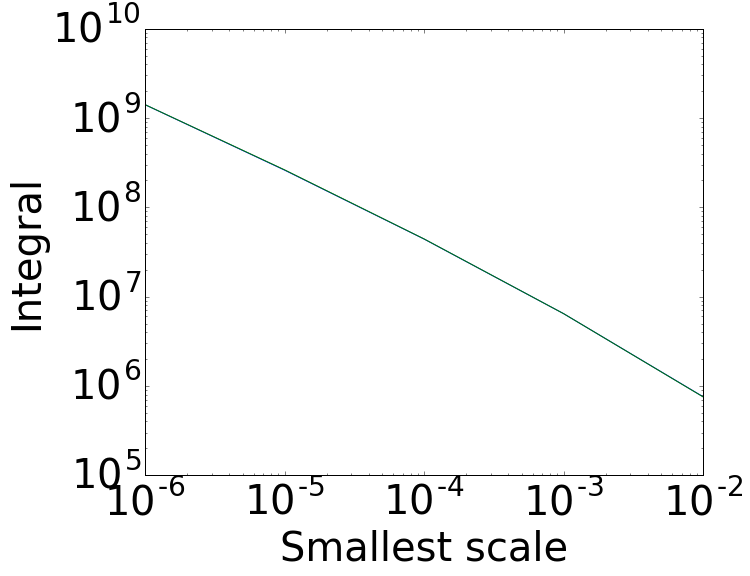

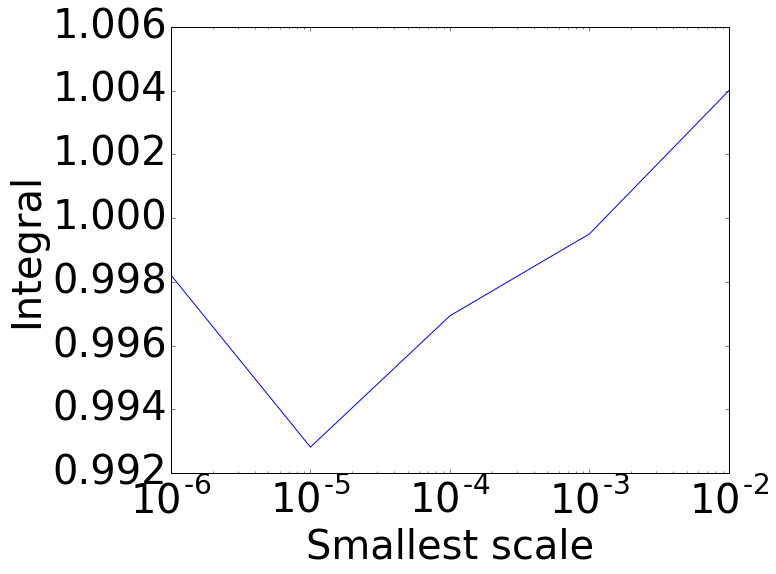

In [76]:
plt.figure(figsize=(10,8))
plt.plot(smallest_length_scale_space,integral_space,label='Numerical integration')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Smallest scale',fontsize=40)
plt.ylabel('Integral',fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

if (TEST_MODE):
    plt.plot(smallest_length_scale_space,test_analytical_integral_space,label='Analytical integration')
    plt.figure(figsize=(10,8))
    plt.plot(smallest_length_scale_space,numpy.array(integral_space)/numpy.array(test_analytical_integral_space),label='Analytical integration')

plt.xlabel('Smallest scale',fontsize=40)
plt.ylabel('Integral',fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)


plt.xscale('log')
#plt.yscale('log')

# Tests for linear dark matter theory: Comparison with Moster and Somerville

In [ ]:
#-----------------------------OVERRIDING DEFAULT INPUTS------------------------------
TEST_MODE=False
PARALLEL_PROCESSORS=True
LINEAR_DARK_MATTER_MODE=True
#------------------------------------------------------------------------------------
survey_type='COSMOS'
prefix='survey_specifications_'
f=open(prefix+survey_type+'.txt')
lines=f.readlines()
for line in lines:
    if ('-------' not in line):
            #line= line.replace('=',' ')
            #line=line.split()
            print line
            exec(line)  
            
            


NON_LINEAR_POWER_SPECTRUM=0
for Number_of_points in [10**6]:

        #print fitted_exponent,fitted_normalization,fitted_exponent_error,fitted_normalization_error
        
        integral_space=[]
        redshift_for_plot=[]
        #an_integral_space=[]
        Number_of_points_space=[5,10,100,1000,10000,100000,10**6][:]

        N=-2
        
        for redshift in [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1,2.3,2.5,2.7,2.9,3.1,3.3,3.5]:
        #for Number_of_points in Number_of_points_space:
#                try:
#                    r_dm,xi_dm=pickle.load(open('./linear_matter_correlation/z%.2f_correlation.pickle'%(redshift)))
#                except:
            try:
                r_dm,xi_dm=pickle.load(open('./linear_matter_correlation/z%.2f_correlation_second_round.pickle'%(redshift)))
                #r_dm_nl,xi_dm_nl=pickle.load(open('../project_3/dm_correlation_functions_mb2/xi_z%.2f.pickle'%redshift))    
                #mask_dm=xi_dm>0
                gen_dm_corr=scipy.interpolate.interp1d(numpy.log10(r_dm[mask_dm]),numpy.log10(xi_dm[mask_dm]),fill_value='extrapolate')
                
                #gen_dm_corr_nl=scipy.interpolate.interp1d(numpy.log10(r_dm_nl[xi_dm_nl>0]),numpy.log10(xi_dm_nl[xi_dm_nl>0]),fill_value='extrapolate')

                dimensions=get_survey_dimensions(redshift,redshift_width,survey_length_in_arc_sec)
                Final_values=numpy.append(dimensions,dimensions)
                smallest_scale=get_survey_dimensions(redshift,redshift_width,survey_resolution_in_arc_sec)[0]
                Initial_values=numpy.array([1e-2]*Dimensions)
                
                print "dimensions:",dimensions
                survey_volume=numpy.product(dimensions)
                
                print "Survey_volume:", survey_volume
                integrals=get_test_integral()
                
                Phase_space_volume_sq=numpy.product(Final_values-Initial_values)
                print "Average correlation function:", integrals/Phase_space_volume_sq
                #print "Volume averaged correlation function", integrals/survey_volume**2
                
                integral_space.append(integrals/survey_volume**2)
                redshift_for_plot.append(redshift)
            except:
                aaa=1






survey_length_in_arc_sec=84.*60.

survey_aspect_ratio=1.0

redshift_width=0.2

survey_resolution_in_arc_sec=0.1





comoving_distance: 421.132207411
comoving_distance: 421.132207411
dimensions: [   7.16863409    7.16863409  573.68235385]
Survey_volume: 29481.1430703
Check Final values: [   7.16863409    7.16863409  573.68235385    7.16863409    7.16863409
  573.68235385]
Check Initial values: [ 0.01  0.01  0.01  0.01  0.01  0.01]
[-2. -2. -2. -2. -2. -2.]
[ 0.85543641  0.85543641  2.75867149  0.85543641  0.85543641  2.75867149]
994397133113.0
Testing the range
parallel calculation
Average correlation function: (0.024958509812-6.43460883691e-16j)
comoving_distance: 1205.27237107
comoving_distance: 1205.27237107
dimensions: [  20.51649449   20.51649449  518.96185202]
Survey_volume: 218444.819961
Check Final values: [  20.51649449   20.51649449  518.96185202   20.51649449   20.51649449
  518.96185202]
Check Initial values: [ 0.01  0.01  0.01  0.01  0.01  0.01]
[-2. -2. -2. -2. -2. -2.]
[

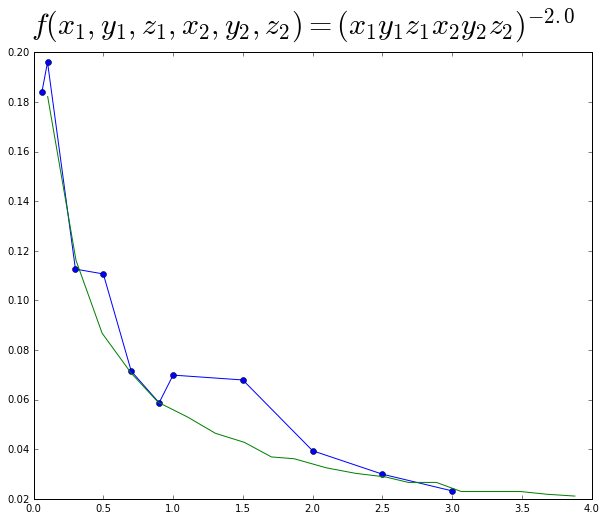

In [89]:
integral_space=numpy.array(integral_space)
cosmic_variance_space=numpy.sqrt(integral_space)

plt.figure(figsize=(10,8))
plt.suptitle('$f(x_1,y_1,z_1,x_2,y_2,z_2)=(x_1 y_1 z_1 x_2 y_2 z_2)^{%.1f}$'%N,fontsize=30)
plt.plot(redshift_for_plot,cosmic_variance_space,label='Numerical integration',marker='o')

data=numpy.loadtxt('./cosmic_variance_cosmos.txt')
plt.plot(data[:,0],data[:,1])

#plt.yscale('log')

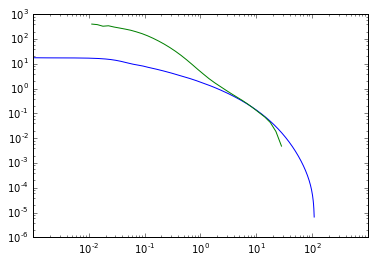

In [29]:
for redshift in [1.0]:
        #for Number_of_points in Number_of_points_space:
                r_dm_l,xi_dm_l=pickle.load(open('./linear_matter_correlation/z%.2f_correlation.pickle'%(redshift)))
                mask_dm=xi_dm>0
                plt.loglog(r_dm_l,xi_dm_l)
                
                r_dm_nl,xi_dm_nl=pickle.load(open('../project_3/dm_correlation_functions_mb2/xi_z%.2f.pickle'%redshift))
                #mask_dm=xi_dm>0
                plt.loglog(r_dm_nl,xi_dm_nl)
                
                
                
                

In [63]:
integral_space

[(0.00011029933138032015-4.0553548067375527e-18j)]

In [ ]:
sur